<a href="https://colab.research.google.com/github.com/Fra-Sala/gnn_time/blob/main/notebook/11_lid_cavity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install PyTorch
try:
  import torch
except ImportError:
  !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
  import torch

In [2]:
# Install PyG
try:
  import torch_geometric
except ImportError:
  !pip3 install torch_geometric
  import torch_geometric

In [3]:
!pip install -Uqq ipdb
import ipdb

In [4]:
# Clone and/or import gca-rom
import sys
if 'google.colab' in str(get_ipython()):
    !git clone https://github.com/Fra-Sala/gnn_time.git
    sys.path.append('gnn_time')
else:
    sys.path.append('./..')
    
from gca_rom import network, pde, loader, plotting, preprocessing, training, initialization, testing, error, gui


In [5]:
import numpy as np
from itertools import product

# Define PDE problem

In [6]:
problem_name, variable, mu_space, n_param = pde.problem(11)
print("\nProblem: ", problem_name)
print("Variable: ", variable)
print("Parameters: ", n_param)
argv = gui.hyperparameters_selection(problem_name, variable, n_param)

# Change the training rate "manually"
argv[5] = 70  
# Sanity check: learn only the "identity" map
#argv[9] = 0.0

HyperParams = network.HyperParams(argv)


Problem:  lid_cavity
Variable:  U
Parameters:  2


# Initialize device and set reproducibility

In [7]:
device = initialization.set_device()
initialization.set_reproducibility(HyperParams)
initialization.set_path(HyperParams)

Device used:  cpu


# Load dataset

In [8]:
if 'google.colab' in str(get_ipython()):
    dataset_dir = '/content/gnn_time/dataset/'+problem_name+'_unstructured.mat'
else:
    dataset_dir = '../dataset/'+problem_name+'_unstructured.mat'
    

    
dataset = loader.LoadDataset(dataset_dir, variable)


#delete the initial condition of each case
dataset.U = np.delete(dataset.U, np.s_[::10], 1)


graph_loader, train_loader, test_loader, \
    val_loader, scaler_all, scaler_test, xyz, VAR_all, VAR_test, \
        train_trajectories, test_trajectories = preprocessing.graphs_dataset(dataset, HyperParams)

#params = torch.tensor(np.array(list(product(*mu_space))))

""" Non-causal approach """

# time = mu_space.pop()
# n_sim = int(len(mu_space[0])/len(time))
# time_tile = np.tile(time, n_sim)
# params = []
# for i in range(len(mu_space[0])):
#         new_set_params = np.concatenate(([mu_space[0][i]], [time_tile[i]]), axis = 0)
#         params.append(new_set_params)

""" Fourier approach """
mu_space_cp = mu_space.copy()
time = mu_space_cp.pop()
params = []
for i in range(len(mu_space_cp[0])):
    set_coeff = [arr[i] for arr in mu_space_cp]
    for j in range(len(time)):
        new_set = np.concatenate((set_coeff, [time[j]]), axis = 0)
        params.append(new_set)

params = torch.tensor(params)
params = params.to(device)
print(params.shape)



Number of nodes processed:  15681
Number of graphs processed:  180
Length of train dataset:  125
Length of test dataset:  55
torch.Size([180, 2])


In [9]:
# # PLOT THE HIGH FIDELITY SOLUTION
# import matplotlib.gridspec as gridspec
# import matplotlib.cm as cm
# from matplotlib import ticker
# from matplotlib.ticker import MaxNLocator
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# import matplotlib.pyplot as plt

# triang = np.asarray(dataset.T - 1)
# snap_vec = np.array([93,44,50,65,71,40,139])

# for SNAP in snap_vec:
#     cmap = cm.get_cmap(name='jet', lut=None)
#     gs1 = gridspec.GridSpec(1, 1)
#     ax = plt.subplot(gs1[0, 0])
#     cs = ax.tricontourf(dataset.xx[:, SNAP], dataset.yy[:, SNAP], triang, dataset.U[:, SNAP], 100, cmap=cmap)
#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes("right", size="5%", pad=0.1)
#     cbar = plt.colorbar(cs, cax=cax)
#     tick_locator = MaxNLocator(nbins=5)
#     cbar.locator = tick_locator
#     cbar.formatter.set_powerlimits((0, 0))
#     cbar.update_ticks()
#     plt.tight_layout()
#     ax.set_aspect('equal', 'box')
#     ax.set_title('Solution field for $\mu$ = '+str(np.around(params[SNAP].detach().numpy(), 2)))
#     plt.savefig('High_fidelity_solutions/High_fidelity_solution_snap_'+str(SNAP)+'.png', bbox_inches='tight', dpi=500)
#     plt.show()

# import matplotlib.gridspec as gridspec
# import matplotlib.cm as cm
# from matplotlib import ticker
# from matplotlib.ticker import MaxNLocator
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# import matplotlib.pyplot as plt

# triang = np.asarray(dataset.T - 1)
# snap_vec = np.array([93,44,50,65,71,40,139])
# max_sol = np.array([7.5e-1, 6e-1, 6.5e-1, 6, 1.5, 1.25, 1.5])

# i = 0
# for SNAP in snap_vec:
#     cmap = cm.get_cmap(name='jet', lut=None)
#     max_val = max_sol[i]
#     gs1 = gridspec.GridSpec(1, 1)
#     ax = plt.subplot(gs1[0, 0])
#     cs = ax.tricontourf(dataset.xx[:, SNAP], dataset.yy[:, SNAP], triang, dataset.U[:, SNAP],np.linspace(0., max_val, 150), cmap=cmap)
#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes("right", size="5%", pad=0.1)
#     cbar = plt.colorbar(cs, cax=cax)
#     tick_locator = MaxNLocator(nbins=5)
#     cbar.locator = tick_locator
#     cbar.formatter.set_powerlimits((0, 0))
#     cbar.update_ticks()
#     plt.tight_layout()
#     ax.set_aspect('equal', 'box')
#     ax.set_title('Solution field for $\mu$ = '+str(np.around(params[SNAP].detach().numpy(), 2)))
#     plt.savefig('untitled/High_fidelity_solution_snap_'+str(SNAP)+'.png', bbox_inches='tight', dpi=500)
#     plt.show()
#     i = i+1



# Define the architecture

In [10]:
model = network.Net(HyperParams)
model = model.to(device)
torch.set_default_dtype(torch.float32)
optimizer = torch.optim.Adam(model.parameters(), lr=HyperParams.learning_rate, weight_decay=HyperParams.weight_decay)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=HyperParams.miles, gamma=HyperParams.gamma)

# Train or load a pre-trained network

In [11]:
try:
    model.load_state_dict(torch.load(HyperParams.net_dir+HyperParams.net_name+HyperParams.net_run+'.pt', map_location=torch.device('cpu')))
    print('Loading saved network')
except FileNotFoundError:
    print('Training network')
    training.train(model, optimizer, device, scheduler, params, train_loader, test_loader, train_trajectories, test_trajectories, HyperParams)

Loading saved network


# Evaluate the model

In [12]:
model.to("cpu")
params = params.to("cpu")
vars = "GCA-ROM"
results, latents_map, latents_gca = testing.evaluate(VAR_all, model, graph_loader, params, HyperParams, range(params.shape[0]))

100%|█████████████████████████████████████████| 180/180 [00:09<00:00, 18.74it/s]


# Plot the results

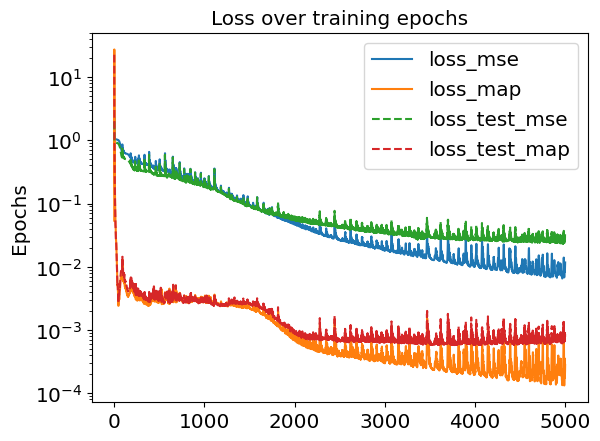

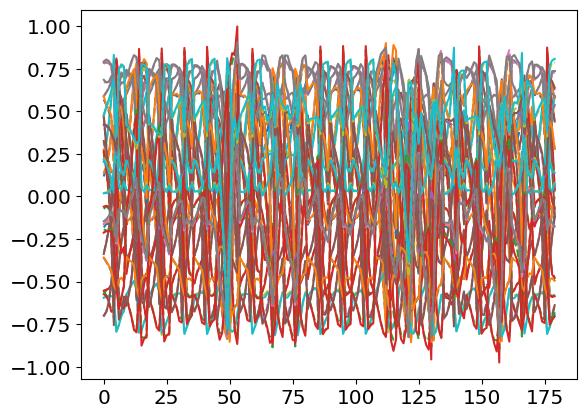

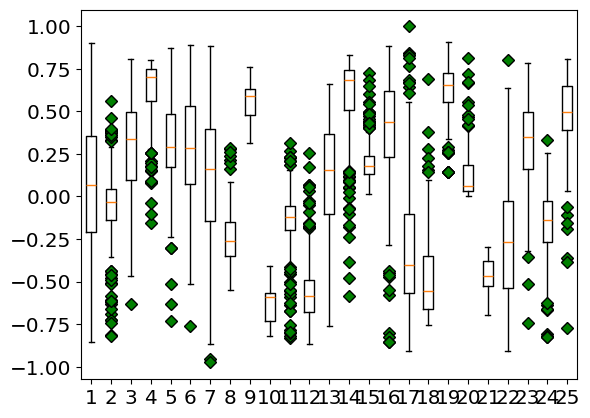

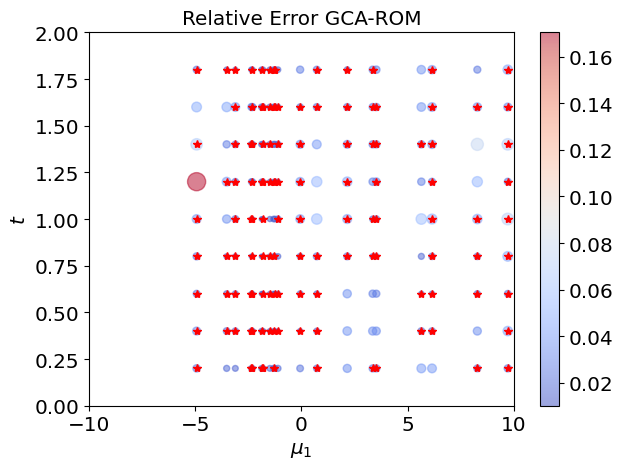

100%|███████████████████████████████████████████| 55/55 [00:03<00:00, 17.92it/s]


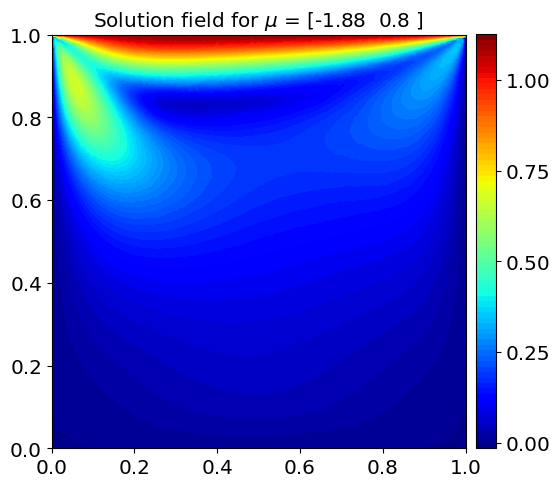

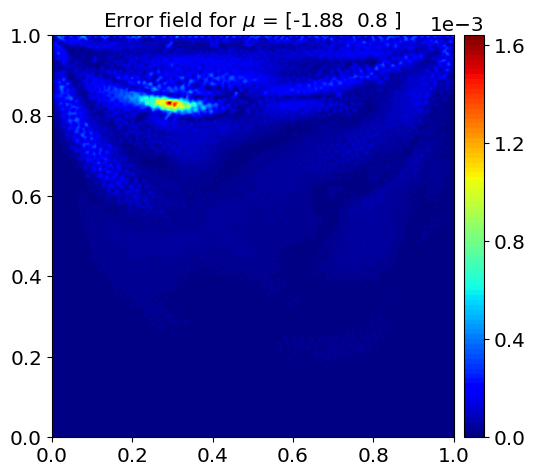

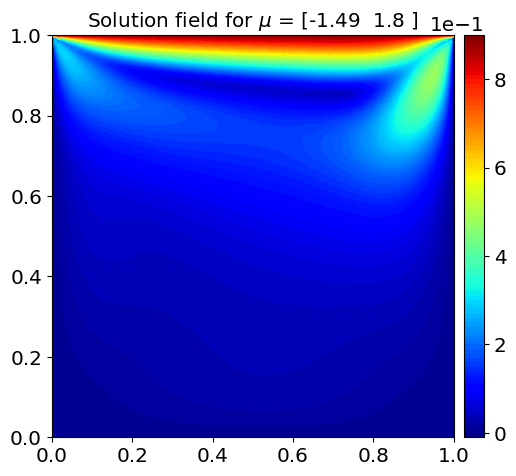

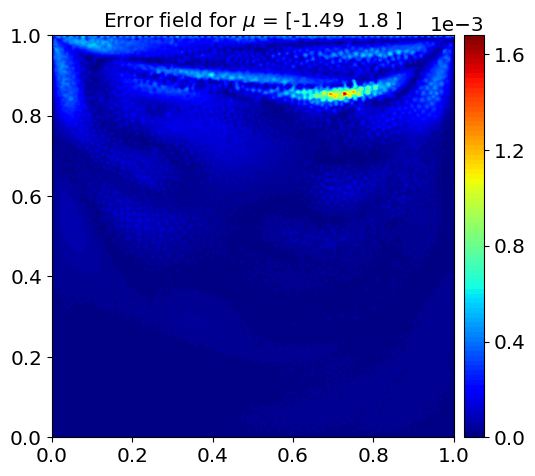

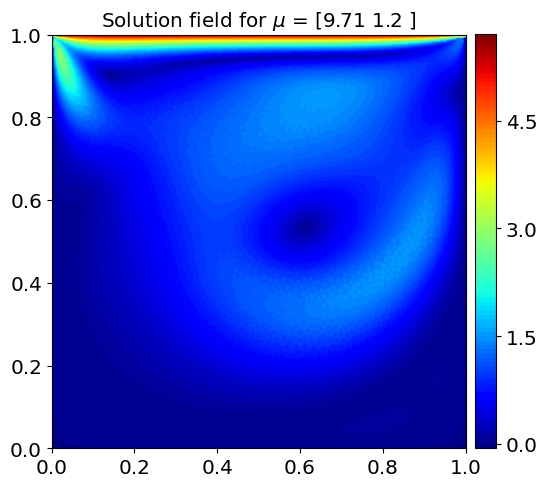

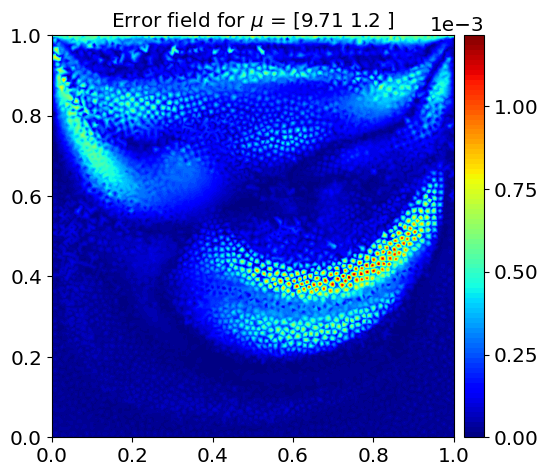

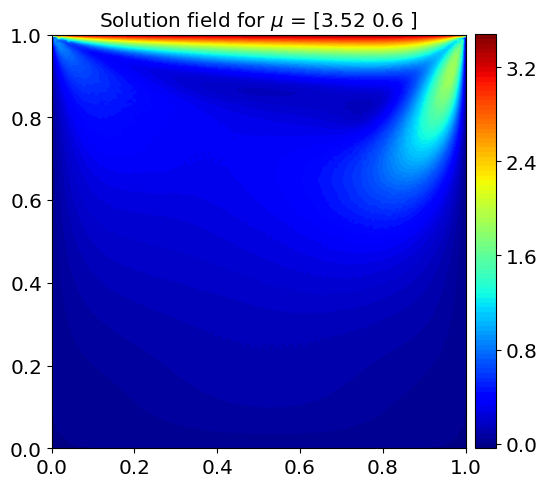

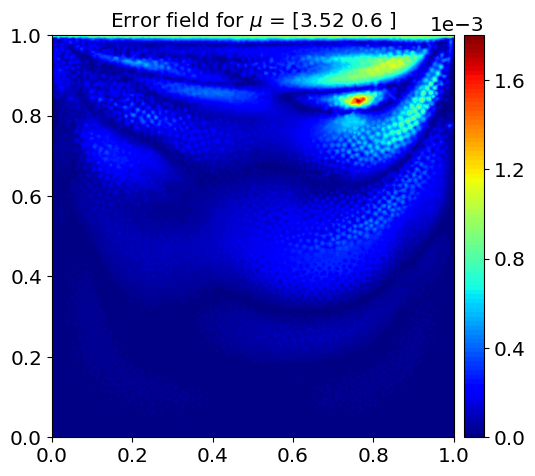

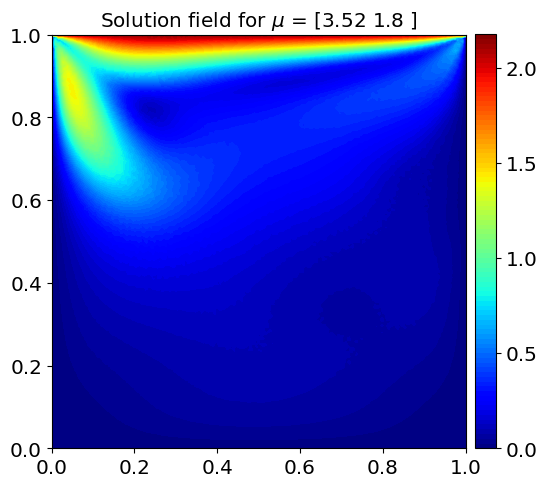

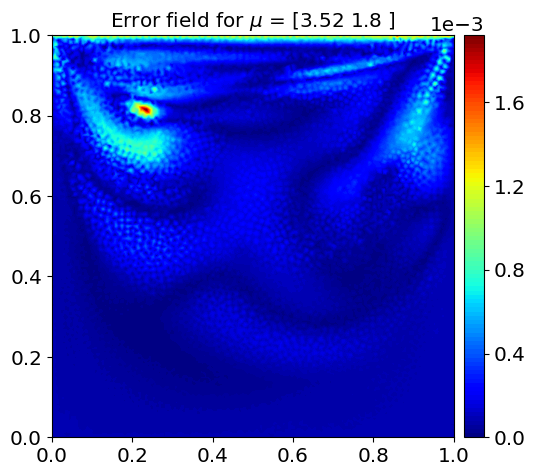

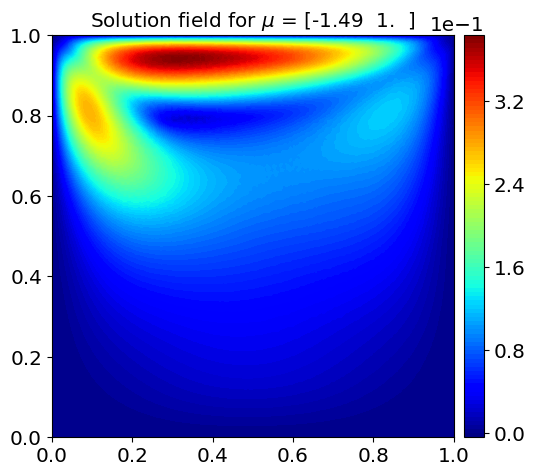

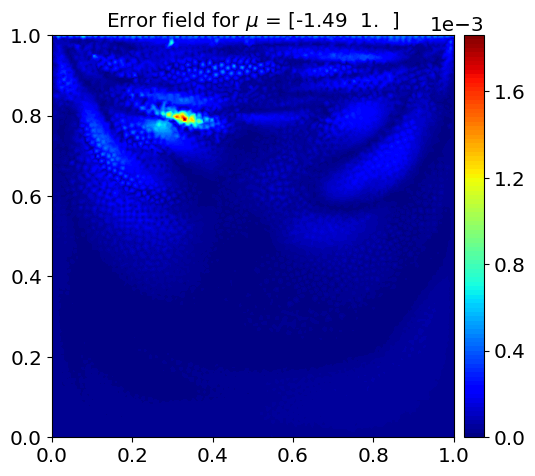

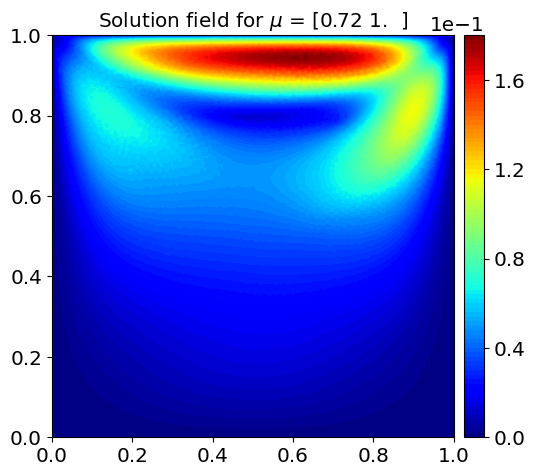

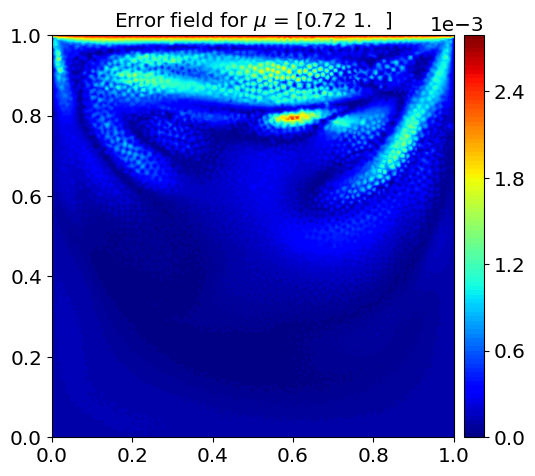

In [13]:
plotting.plot_loss(HyperParams)
plotting.plot_latent(HyperParams, latents_map, latents_gca)
plotting.plot_error_multip(results, VAR_all, scaler_all, HyperParams, mu_space, params, train_trajectories, vars)

#N = 10
#snapshots = np.arange(params.shape[0]).tolist()
#np.random.shuffle(snapshots)
snapshots = np.array([93,44,50,65,71,40,139])
for SNAP in snapshots:
    plotting.plot_fields(SNAP, results, scaler_all, HyperParams, dataset, xyz, params)
    plotting.plot_error_fields(SNAP, results, VAR_all, scaler_all, HyperParams, dataset, xyz, params)

results_test, _, _ = testing.evaluate(VAR_test, model, val_loader, params, HyperParams, test_trajectories)

# Print the errors on the testing set

In [14]:
error_abs, norm = error.compute_error(results_test, VAR_test, scaler_test, HyperParams)
error.print_error(error_abs, norm, vars)
error.save_error(error_abs, norm, HyperParams, vars)


Maximum absolute error for field GCA-ROM =  15.182359176027886
Mean absolute error for field GCA-ROM =  2.4896809416125643
Minimum absolute error for field GCA-ROM =  0.023467725182068952

Maximum relative error for field GCA-ROM =  0.17330618636893505
Mean relative error for field GCA-ROM =  0.04366249393131256
Minimum relative error for field GCA-ROM =  0.020800358307914463


In [15]:
#!zip -r /content/lid_cavity.zip /content/lid_cavity